# Move existing user content to a new user
This sample illustrates how to "move" a portal user's account to a new user account.  This is accomplished by creating a new user account, assigning ownership/membership of this new user to all the applicable groups, and then reassigning the old user's content to the new user connect while maintaining folder structure under 'My Contents'.

For some customers, this is a useful utility when they have used one type of Identity store, e.g. Built-in Users, and then decided to switch to a different Identity provider, such as SAML or IWA.  In these situations, it is highly likely new userids will be created as new user accounts get created.  This Jupyter Notebook is an example of how to use the Python API to take a user's content and migrate it to a new userid while maintaining all group membership and content (including folders in My Content).

In [ ]:
from arcgis.gis import *
from IPython.display import display

Create a connection to the portal.  In this case, we will exercise the verify_cert option to not validate the SSL certificate (True by default).

In [ ]:
gis = GIS("https://python.playground.esri.com/portal", "arcgis_python", "amazing_arcgis_123") 

Establish variables for the current userid that is being transitioned and for the new userid to be created (e.g. a new Single Sign-on username).

In [ ]:
orig_userid = "First_User"
new_userid = "Second_User"

Validate that the original userid is valid and accessible.

<User username:First_User>
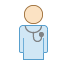

In [ ]:
olduser = gis.users.get(orig_userid)
olduser

Create a new userid, making sure to use `provider='enterprise'` if Web Tier Authentication is going to be used.  If moving user accounts from one userid to another, make sure that a proper password is used that meets security requirements.

In [ ]:
newuser = gis.users.create(username = new_userid,
                            password = "pwdNotUsed",
                            firstname = olduser.firstName,
                            lastname = olduser.lastName,
                            email = olduser.email,
                            description = olduser.description,
                            role = olduser.role,
                            provider = 'enterprise',
                            idp_username=None)   

Once the new user has been successfully created, reassign group ownership and group membership from the old user to the new user.

In [ ]:
usergroups = olduser['groups']

for group in usergroups:
    grp = gis.groups.get(group['id'])
    if (grp.owner == orig_userid):
        grp.reassign_to(new_userid)
    else:
        grp.add_users(new_userid)
        grp.remove_users(orig_userid)

Once group ownership/membership has been successfully changed, reassign all the original user's content to the new user.  This happens in 2 passes.  First, reassign everything on the root folder of 'My Contents'.  Then, loop over each folder, create the same folder in the new user account, and reassign items in each folder to the new user in the correct folder.

In [ ]:
usercontent = olduser.items()

folders = olduser.folders
for item in usercontent:
    try:
        item.reassign_to(new_userid)
    except Exception as e:
        print("Item may have been already assigned to the user.")

for folder in folders:
    gis.content.create_folder(folder['title'], new_userid)
    folderitems = olduser.items(folder=folder['title'])
    for item in folderitems:
        item.reassign_to(new_userid, target_folder=folder['title'])

Item does not exist or is inaccessible.


Item may have been already assigned to the user.
